In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2018-01-01',
    'to': '2018-12-01',
    'categories': ['PLAT']
}, model_params = {
    'kfolds': 2,
    'nan_flag': 100000,
    'n_targets': 3
})

loading data 2fc5440880284b359b912555533cf7ab from cache
preparing model data
training xgb_10
training xgb_30
training xgb_100
training knn_1
training knn_2
training knn_3
training knn_4
training knn_5
training knn_6
training knn_7
training knn_8
training knn_9
training knn_10
training knn_20
training knn_30
training xgb_10
training xgb_30
training xgb_100
training knn_1
training knn_2
training knn_3
training knn_4
training knn_5
training knn_6
training knn_7
training knn_8
training knn_9
training knn_10
training knn_20
training knn_30
preparing stacked model data
training xgb
mea: 1.4172619055197748
training mlp_sigmoid
mea: 1.461839408691141
training mlp_sigmoid_100
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
mea: 2.548505554021

In [4]:
len(program.model.models[0]['estimators'])
program.model.hash

'f824b93e397f34cffbd0a087a0dc2843'

In [5]:
#program.dataset.save()
#program.model.save()

In [6]:
#program.lock('2019-01-24')

In [7]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

5805 races from 2018-01-01 12:52:00 to 2018-11-30 19:30:00


In [8]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]


In [9]:
pd.set_option('precision',7)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


for model in program.model.stacked_models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
        
pd.set_option('precision',7)



xgb_10
declared_player_count                              0.2952381
hist_1_pos                                         0.2190476
victory_earnings_r                                 0.1952381
handicap_weight_r                                  0.1095238
num                                                0.0476190
placed_earnings_r                                  0.0333333
victory_earnings                                   0.0238095
race_count_r                                       0.0142857
placed_2_count_r                                   0.0142857
placed_earnings                                    0.0095238
placed_earnings_amin                               0.0095238
odds_6                                             0.0095238
victory_earnings_std                               0.0095238
victory_count                                      0.0047619
race_count_mean                                    0.0047619
odds_7                                             0.0000000
odds_3           

In [10]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_10 0.24768394388846254
xgb_30 0.1932129817561502
xgb_100 0.18257564012580993
knn_1 0.19097156844285446
knn_2 0.19046162053599447
knn_3 0.19027594719554802
knn_4 0.18944957007468777
knn_5 0.1895186091759242
knn_6 0.18929789326136529
knn_7 0.18909092539294
knn_8 0.18903572773488986
knn_9 0.18895269775518317
knn_10 0.18882194188162932
knn_20 0.18753373501537685
knn_30 0.18635013284796753


In [11]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)

exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos', 'target_returns'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count         sub_category  num  \
race_id                                                                    
52582   43234       1.0                     16  COURSE_A_CONDITIONS    8   
        43227       2.0                     16  COURSE_A_CONDITIONS    1   
        43238       3.0                     16  COURSE_A_CONDITIONS   12   
        43240       4.0                     16  COURSE_A_CONDITIONS   14   
        43239       5.0                     16  COURSE_A_CONDITIONS   13   
        43237       6.0                     16  COURSE_A_CONDITIONS   11   
        43241       7.0                     16  COURSE_A_CONDITIONS   15   
        43228       8.0                     16  COURSE_A_CONDITIONS    2   
        43229       9.0                     16  COURSE_A_CONDITIONS    3   
        43236      10.0                     16  COURSE_A_CONDITIONS   10   
        43235      11.0                     16  COURSE_A_CONDITIONS    9   
        43242      12.0                     16  COURSE_A_CONDITIONS   16   
        43231      13.0                     16  COURSE_A_CONDITIONS    5   
        43230      14.0                     16  COURSE_A_CONDITIONS    4   
        43232      15.0                     16  COURSE_A_CONDITIONS    6   
        43233      16.0                     16  COURSE_A_CONDITIONS    7   

               final_odds  final_odds_ref  target_pos  target_returns  \
race_id                                                                 
52582   43234         9.8             5.4           1             9.8   
        43227        27.3            31.2           1             0.0   
        43238         5.6            12.4           2             0.0   
        43240        14.7            11.3           2             0.0   
        43239        11.0            18.9           3             0.0   
        43237         3.1             2.6           3             0.0   
        43241        33.4            45.5           3             0.0   
        43228        11.4            13.8           3             0.0   
        43229        10.9            11.1           3             0.0   
        43236       102.0           132.8           3             0.0   
        43235       221.7            66.4           3             0.0   
        43242        12.9            15.4           3             0.0   
        43231       119.1            33.2           3             0.0   
        43230        20.5            28.4           3             0.0   
        43232       199.4           109.6           3             0.0   
        43233       306.2           106.3           3             0.0   

               pred_xgb_10_1  pred_xgb_30_1  pred_xgb_100_1  pred_knn_1_1  \
race_id                                                                     
52582   43234      0.2368466      0.1916474       0.1664206           1.0   
        43227      0.2342378      0.1810645       0.1493489           0.0   
        43238      0.2378938      0.2236632       0.2415941           0.0   
        43240      0.2519325      0.2027276       0.2241527           1.0   
        43239      0.2285232      0.1978132       0.1920977           1.0   
        43237      0.2317244      0.2195449       0.2266504           0.0   
        43241      0.2467866      0.1850497       0.1569292           0.0   
        43228      0.2597206      0.2123113       0.1536713           0.0   
        43229      0.2591824      0.2350501       0.1864959           0.0   
        43236      0.2391042      0.1291965       0.0673481           0.0   
        43235      0.1884407      0.0944697       0.0576342           0.0   
        43242      0.1873500      0.0960182       0.0848035           0.0   
        43231      0.2546842      0.1805346       0.1187018           0.0   
        43230      0.2493249      0.1915261       0.1414797           0.0   
        43232      0.1874382      0.0886563       0.0464439           0.0   
        43233      0.1

In [12]:
#df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)
#df['pred_sum'] = df[['pred_knn_{}_1'.format(n) for n in [5,10,20,30]]].sum(axis=1)
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''


"\nfor model in program.model.models:\n    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)\n    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)\n"

In [13]:
df['pred_rnd'] = np.random.rand(df.shape[0])

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
'''

"\nfor model in program.model.models:\n    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n    \nfor model in program.model.stacked_models:\n    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n"

In [14]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [15]:
program.model.features

['declared_player_count',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',
 'placed_3_count_amax',
 'placed_3_count_amin',
 'placed_3_count_mean',
 'placed_3_count_r',
 'placed_3_count_std',
 'placed_earnings',
 'placed_earnings_amax',
 'placed_earnings_amin',
 'placed_earnings_mean',
 'placed_earnings_r',
 'placed_earnings_std',
 'prev_year_earnings',
 'prev_year_earnings_amax',
 'prev_yea

In [16]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [17]:
def bet2(df):

    races = df.sort_values('start_at').groupby('race_id')
    
    bet = 0
    profit = 0
    
  
    strats = [
            [1, 1, 1],
            [0, 1, 1, 1],
            [0, 0, 1, 1, 1],
            [0, 0, 0, 1, 1, 1],
            [0, 0, 0, 0, 1, 1, 1],
        ]


    
    for (id, race) in races:

        r = race.sort_values(by='final_odds_ref', ascending=True)
        
        '''
        if r.iloc[0]['final_odds_ref'] > 20:
            continue
            
        if r.iloc[0]['final_odds_ref'] < 3:
            continue
        
        bet += 1
        profit += r.iloc[0]['winner_dividend']/100.0 * 1 - 1
        
        continue
        '''
        

        si = int(list(r['pred_xgb_100'].value_counts().index)[0])
        
        if si == 0:
            continue
            
        strat = strats[si-1]
        
        
        for n in range(len(strat)):
            
            if r.iloc[n]['final_odds_ref'] > 20 or r.iloc[n]['final_odds_ref'] < 3:
                continue
            
            bet += strat[n]
            profit += r.iloc[n]['winner_dividend']/100.0 * strat[n] - strat[n]

        
        '''
        for strat in strats:
            for n in range(len(strat)):
                if len(r) <= n:
                    break
                b = strat[n] * r.iloc[0]['pred_xgb_100_{}'.format(n+1)]
                bet += b
                profit += r.iloc[n]['winner_dividend']/100.0 * b - b
        '''
    
    return (bet, profit)
        

        

In [18]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=1, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    

"\n['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [19]:
bets['profit'].describe()

count    301860.0000000
mean         -0.2852352
std           3.2365975
min          -1.0000000
25%          -1.0000000
50%          -1.0000000
75%          -1.0000000
max         146.0000000
Name: profit, dtype: float64

In [20]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

,pred_xgb_10_1,pred_xgb_30_1,pred_xgb_100_1,pred_knn_1_1,pred_knn_2_1,pred_knn_3_1,pred_knn_4_1,pred_knn_5_1,pred_knn_6_1,pred_knn_7_1,pred_knn_8_1,pred_knn_9_1,pred_knn_10_1,pred_knn_20_1,pred_knn_30_1
count,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000,63732.0000000
mean,0.2476839,0.1932130,0.1825756,0.1909716,0.1904616,0.1902759,0.1894496,0.1895186,0.1892979,0.1890909,0.1890357,0.1889527,0.1888219,0.1875337,0.1863501
std,0.0370536,0.0666513,0.0924996,0.3930698,0.2767114,0.2248056,0.1951142,0.1747935,0.1597607,0.1495481,0.1415129,0.1351719,0.1294159,0.1001459,0.0886315
min,0.1760949,0.0646940,0.0146002,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,0.2194202,0.1414505,0.1104207,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.1428571,0.1250000,0.1111111,0.1000000,0.1000000,0.1333333
50%,0.2448390,0.1854021,0.1667413,0.0000000,0.0000000,0.0000000,0.2500000,0.2000000,0.1666667,0.1428571,0.1250000,0.2222222,0.2000000,0.2000000,0.1666667
75%,0.2702833,0.2356507,0.2377656,0.0000000,0.5000000,0.3333333,0.2500000,0.4000000,0.3333333,0.2857143,0.2500000,0.2222222,0.3000000,0.2500000,0.2333333
max,0.3735380,0.4828212,0.7267666,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.8571429,0.8750000,0.8888889,0.8000000,0.6500000,0.6333333


In [21]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [33]:
list(bets.columns)

['id',
 'date',
 'num',
 'pos',
 'nb',
 'odds_ref',
 'odds_final',
 'target',
 'pred',
 'pred_std',
 'bet',
 'profit',
 'profit_placed',
 'next_pred_1',
 'next_pred_2',
 'next_pred_3',
 'declared_player_count',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',
 'placed_3_count_amax',
 'placed_3_count_amin',
 'placed_3_count_mean',
 'placed_3_count_r',
 'placed_3_count_std',
 'placed_earnings

In [22]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [23]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

Stored 'countries' (list)
Stored 'sub_categories' (list)


In [24]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] >= params['min_pred']) & (b['pred'] <= params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [25]:
c_mean, c_min, c_max

(0.8926787252368648, 0.0, 1.0)

In [26]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = dummy_minimize(f, space, n_calls=500)

In [27]:
#x_to_params(res.x), res.fun

In [28]:
#params = x_to_params(res.x)
#%store params
#params

In [29]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [30]:
#bb = ff(params, False)

                                                          avg  bet  bets  \
idx_1               idx_2                                                  
COURSE_A_CONDITIONS pred_stacked_xgb_1              0.1108235  425   425   
                    pred_knn_30_1                   0.0278761  452   452   
                    pred_xgb_10_2                  -0.0429054  592   592   
                    pred_knn_20_1                  -0.0809422  467   467   
                    pred_knn_7_1                   -0.0899209  506   506   
                    pred_sum                       -0.0993088  434   434   
                    pred_knn_10_1                  -0.1382231  484   484   
                    pred_knn_10_3                  -0.1573402  579   579   
                    pred_knn_3_1                   -0.1635593  472   472   
                    pred_knn_6_1                   -0.1665975  482   482   
                    pred_xgb_10_3                  -0.1817544  570   570   
            

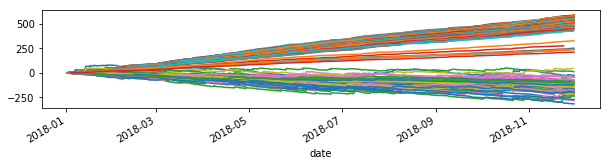

                                               avg  bet  bets  profit  \
idx_1    idx_2                                                          
HANDICAP pred_knn_3_1                    0.0349862  363   363    12.7   
         pred_stacked_mlp_sigmoid_1      0.0162338  154   154     2.5   
         pred_knn_4_1                    0.0047222  360   360     1.7   
         pred_knn_10_2                   0.0018127  331   331     0.6   
         pred_knn_9_1                   -0.0590504  337   337   -19.9   
         pred_knn_5_2                   -0.0809942  342   342   -27.7   
         pred_knn_30_1                  -0.0905844  308   308   -27.9   
         pred_knn_1_1                   -0.0951220  287   287   -27.3   
         pred_knn_20_2                  -0.1083565  359   359   -38.9   
         pred_knn_6_2                   -0.1193084  347   347   -41.4   
         pred_sum                       -0.1284848  330   330   -42.4   
         pred_knn_8_3                   -0.1307692 

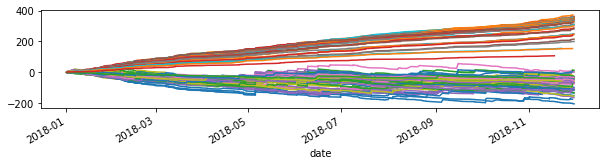

                                                      avg  bet  bets  profit  \
idx_1           idx_2                                                          
HANDICAP_DIVISE pred_rnd                        0.2850187  267   267    76.1   
                pred_knn_6_2                    0.2441509  265   265    64.7   
                pred_knn_4_2                    0.2021978  273   273    55.2   
                pred_knn_5_2                    0.1816479  267   267    48.5   
                pred_knn_8_2                    0.1426573  286   286    40.8   
                pred_knn_3_2                    0.0876404  267   267    23.4   
                pred_knn_9_2                    0.0536496  274   274    14.7   
                pred_knn_7_1                    0.0380597  268   268    10.2   
                pred_knn_2_3                    0.0380392  255   255     9.7   
                pred_stacked_mlp_sigmoid_1      0.0074074  162   162     1.2   
                pred_knn_7_2            

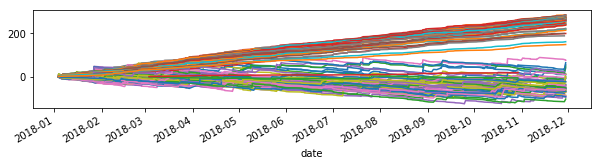

                                                 avg  bet  bets  profit  \
idx_1      idx_2                                                          
A_RECLAMER pred_knn_20_2                   0.3597315  149   149    53.6   
           pred_stacked_mlp_relu_100_1     0.3258741  143   143    46.6   
           pred_knn_7_2                    0.3171975  157   157    49.8   
           pred_xgb_100_2                  0.2561905  105   105    26.9   
           pred_knn_8_2                    0.0882353  153   153    13.5   
           pred_knn_5_2                    0.0734177  158   158    11.6   
           pred_xgb_10_2                   0.0689441  161   161    11.1   
           pred_knn_9_2                    0.0629139  151   151     9.5   
           pred_knn_30_2                   0.0350649  154   154     5.4   
           pred_knn_6_1                    0.0154930  142   142     2.2   
           pred_xgb_100_1                 -0.0333333   39    39    -1.3   
           pred_knn_9_1  

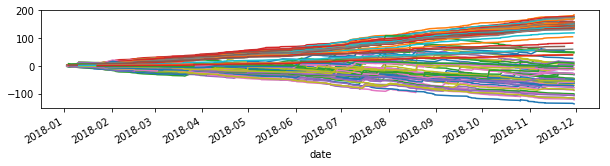

                                                                avg  bet  \
idx_1                     idx_2                                            
HANDICAP_CATEGORIE_DIVISE final_odds_ref                  5.8000000    5   
                          pred_stacked_mlp_sigmoid_100_1  0.9446809   47   
                          pred_knn_9_2                    0.2627273  110   
                          pred_xgb_30_3                   0.2320988   81   
                          pred_knn_2_3                    0.1686957  115   
                          pred_knn_1_3                    0.1454545  110   
                          pred_knn_10_2                   0.1377049  122   
                          pred_knn_1_1                    0.1086957   92   
                          pred_knn_20_3                   0.1080460   87   
                          pred_knn_10_3                   0.0723404   94   
                          pred_xgb_10_3                   0.0367816   87   
            

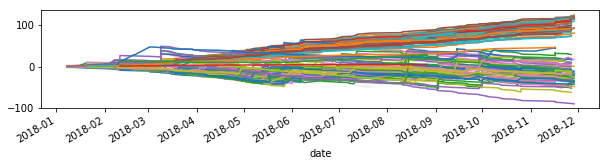

                                                            avg  bet  bets  \
idx_1                 idx_2                                                  
HANDICAP_DE_CATEGORIE pred_knn_1_2                    0.7404762   42    42   
                      pred_rnd                        0.5838710   62    62   
                      pred_xgb_30_2                   0.4810811   37    37   
                      pred_knn_30_1                   0.4803571   56    56   
                      pred_knn_20_1                   0.4528302   53    53   
                      pred_knn_10_1                   0.4245614   57    57   
                      pred_knn_1_1                    0.3425926   54    54   
                      pred_xgb_30_1                   0.2314286   35    35   
                      pred_knn_3_2                    0.1426230   61    61   
                      pred_xgb_30_3                   0.1108696   46    46   
                      pred_knn_20_2                   0.1087719 

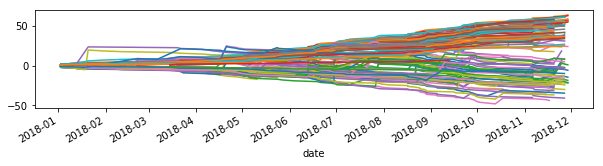

                                               avg  bet  bets  profit  \
idx_1    idx_2                                                          
GROUPE_I pred_stacked_mlp_relu_100_1     3.8000000   11    11    41.8   
         pred_xgb_10_3                   2.1705882   17    17    36.9   
         pred_xgb_30_3                   2.1705882   17    17    36.9   
         pred_sum                        1.9869565   23    23    45.7   
         pred_knn_2_1                    1.5103448   29    29    43.8   
         pred_xgb_100_3                  1.4666667   18    18    26.4   
         pred_knn_30_3                   1.4612903   31    31    45.3   
         pred_knn_3_1                    0.6444444   27    27    17.4   
         pred_rnd                        0.2269231   26    26     5.9   
         pred_knn_1_1                    0.1521739   23    23     3.5   
         pred_knn_20_1                   0.1318182   22    22     2.9   
         pred_xgb_30_1                   0.1214286 

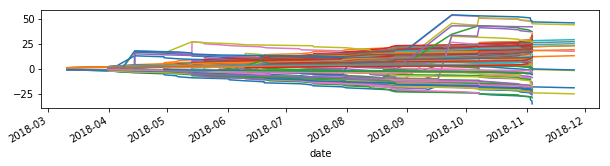

                                                 avg  bet  bets  profit  \
idx_1      idx_2                                                          
GROUPE_III pred_xgb_10_1                   1.4363636   11    11    15.8   
           pred_knn_7_1                    0.5368421   19    19    10.2   
           pred_xgb_30_2                   0.5304348   23    23    12.2   
           pred_xgb_10_2                   0.5181818   22    22    11.4   
           pred_knn_3_3                    0.5160000   25    25    12.9   
           pred_knn_7_2                    0.4909091   22    22    10.8   
           pred_knn_2_2                    0.4607143   28    28    12.9   
           final_odds_ref                  0.4250000   20    20     8.5   
           pred_knn_5_3                    0.4038462   26    26    10.5   
           pred_knn_5_2                    0.3684211   19    19     7.0   
           pred_knn_4_3                    0.3633333   30    30    10.9   
           pred_knn_4_1  

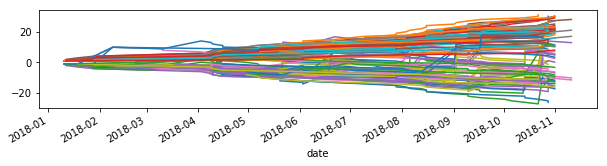

                                                                   avg  bet  \
idx_1                        idx_2                                            
COURSE_A_CONDITION_QUALIF_HP pred_xgb_100_2                  1.2937500   16   
                             pred_knn_4_2                    1.1875000   24   
                             pred_knn_5_2                    1.1000000   25   
                             pred_knn_2_2                    0.8954545   22   
                             pred_xgb_10_1                   0.8714286   14   
                             final_odds_ref                  0.7333333    6   
                             pred_knn_3_2                    0.6884615   26   
                             pred_knn_1_1                    0.5434783   23   
                             pred_knn_10_2                   0.5400000   25   
                             pred_stacked_xgb_1              0.5111111   18   
                             pred_rnd               

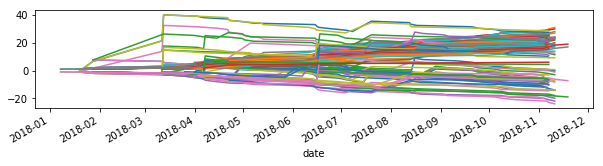

                                                avg  bet  bets  profit  \
idx_1     idx_2                                                          
GROUPE_II pred_stacked_mlp_sigmoid_100_1  2.6428571    7     7    18.5   
          pred_knn_20_2                   1.0611111   18    18    19.1   
          pred_xgb_10_2                   1.0473684   19    19    19.9   
          pred_stacked_mlp_relu_100_1     0.9800000    5     5     4.9   
          pred_xgb_10_1                   0.9500000   10    10     9.5   
          pred_knn_3_2                    0.9461538   13    13    12.3   
          pred_knn_5_1                    0.3368421   19    19     6.4   
          pred_knn_20_3                   0.3000000   22    22     6.6   
          pred_knn_30_2                   0.2782609   23    23     6.4   
          pred_knn_7_3                    0.1789474   19    19     3.4   
          pred_xgb_10_3                   0.1200000   20    20     2.4   
          pred_knn_8_2                

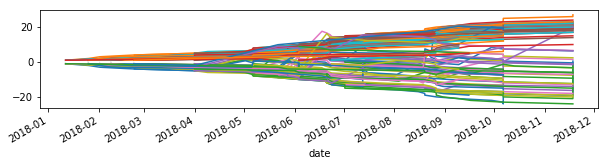

                                              avg  bet  bets  profit  \
idx_1   idx_2                                                          
INCONNU pred_knn_10_3                   3.5000000   14    14    49.0   
        pred_knn_8_3                    2.9375000   16    16    47.0   
        pred_knn_7_3                    2.7058824   17    17    46.0   
        pred_knn_6_3                    2.5733333   15    15    38.6   
        pred_knn_9_3                    2.5214286   14    14    35.3   
        pred_stacked_mlp_sigmoid_100_1  2.4750000    4     4     9.9   
        pred_knn_20_3                   1.7777778    9     9    16.0   
        pred_knn_2_3                    1.6800000   20    20    33.6   
        pred_xgb_30_3                   0.9720000   25    25    24.3   
        pred_xgb_10_3                   0.8961538   26    26    23.3   
        pred_stacked_xgb_1              0.8200000   10    10     8.2   
        pred_xgb_100_3                  0.7681818   22    22    

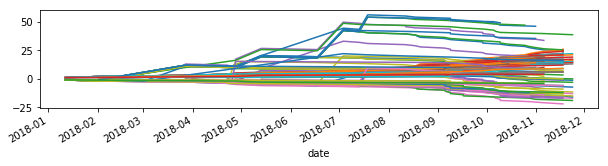

                                                    avg  bet  bets  profit  \
idx_1               idx_2                                                    
HANDICAP_A_RECLAMER pred_knn_30_2                   5.8    1     1     5.8   
                    pred_xgb_30_1                   5.8    1     1     5.8   
                    pred_xgb_10_1                   5.8    1     1     5.8   
                    pred_xgb_100_1                  5.8    1     1     5.8   
                    pred_knn_7_2                   -1.0    2     2    -2.0   
                    pred_knn_2_3                   -1.0    1     1    -1.0   
                    pred_stacked_mlp_sigmoid_1     -1.0    1     1    -1.0   
                    pred_knn_5_2                   -1.0    1     1    -1.0   
                    pred_knn_20_2                  -1.0    1     1    -1.0   
                    pred_xgb_100_2                 -1.0    1     1    -1.0   
                    pred_knn_20_1                  -1.0    1    

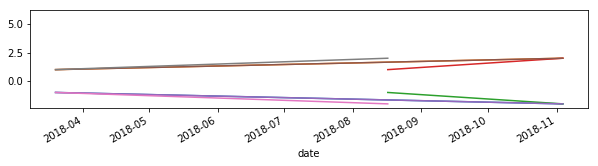

                                      avg  bet  bets  profit  profit_place
idx_1                 idx_2                                               
COURSE_INTERNATIONALE pred_knn_10_2  -1.0    2     2    -2.0          -2.0
                      pred_knn_2_3   -1.0    1     1    -1.0          -1.0
                      pred_knn_30_2  -1.0    1     1    -1.0          -1.0
                      pred_knn_10_1  -1.0    1     1    -1.0           0.1
                      pred_knn_1_3   -1.0    1     1    -1.0          -1.0
                      pred_knn_9_1   -1.0    1     1    -1.0          -1.0
                      pred_knn_4_3   -1.0    1     1    -1.0          -1.0
                      pred_knn_3_3   -1.0    1     1    -1.0          -1.0
                      pred_knn_3_2   -1.0    1     1    -1.0          -1.0
                      pred_knn_8_1   -1.0    1     1    -1.0           0.1
                      pred_rnd       -1.0    1     1    -1.0          -1.0
                      pre

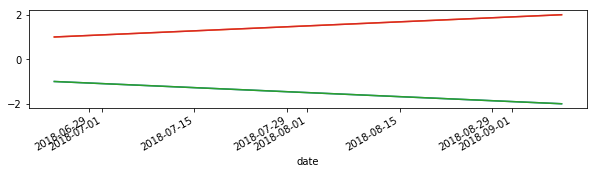

                      avg  bet  bets  profit  profit_place
idx_1 idx_2                                               
MIXTE final_odds_ref -1.0    1     1    -1.0          -1.0
      pred_xgb_100_3 -1.0    1     1    -1.0          -1.0
      pred_knn_9_2   -1.0    1     1    -1.0          -1.0
      pred_knn_2_2   -1.0    1     1    -1.0          -1.0
      pred_knn_8_3   -1.0    1     1    -1.0          -1.0
      pred_xgb_10_3  -1.0    1     1    -1.0          -1.0
      pred_knn_30_2  -1.0    1     1    -1.0          -1.0
      pred_knn_9_3   -1.0    1     1    -1.0          -1.0
      pred_knn_4_1   -1.0    1     1    -1.0          -1.0
      pred_knn_10_3  -1.0    1     1    -1.0          -1.0
      pred_knn_8_2   -1.0    1     1    -1.0          -1.0
      pred_knn_7_3   -1.0    1     1    -1.0          -1.0
      pred_knn_3_1   -1.0    1     1    -1.0          -1.0
      pred_xgb_30_3  -1.0    1     1    -1.0          -1.0
      pred_knn_20_3  -1.0    1     1    -1.0          -1

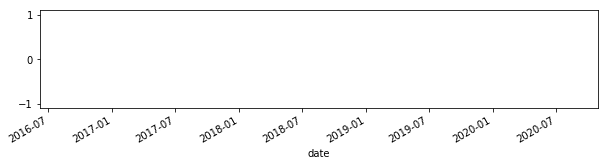

                                       avg  bet  bets  profit  profit_place
idx_1                  idx_2                                               
FINALE_REGIONALE_ACCAF final_odds_ref -1.0    1     1    -1.0          -1.0
                       pred_xgb_100_3 -1.0    1     1    -1.0          -1.0
                       pred_knn_1_2   -1.0    1     1    -1.0          -1.0
                       pred_knn_2_2   -1.0    1     1    -1.0          -1.0
                       pred_knn_8_3   -1.0    1     1    -1.0          -1.0
                       pred_knn_30_2  -1.0    1     1    -1.0          -1.0
                       pred_knn_9_3   -1.0    1     1    -1.0          -1.0
                       pred_knn_5_3   -1.0    1     1    -1.0          -1.0
                       pred_knn_8_2   -1.0    1     1    -1.0          -1.0
                       pred_knn_7_3   -1.0    1     1    -1.0          -1.0
                       pred_knn_20_1  -1.0    1     1    -1.0          -1.0
            

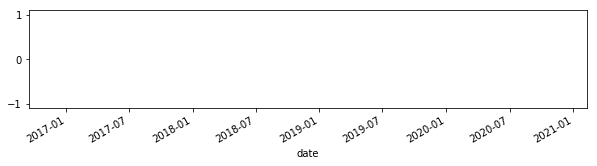

                                     avg  bet  bets  profit  profit_place
idx_1               idx_2                                                
QUALIFICATION_ACCAF pred_knn_30_2   3.25    2     2     6.5           2.4
                    pred_knn_8_2   -1.00    1     1    -1.0           0.2
                    pred_knn_30_1  -1.00    1     1    -1.0           0.2
                    pred_knn_10_1  -1.00    1     1    -1.0          -1.0
                    pred_knn_5_1   -1.00    1     1    -1.0          -1.0
                    pred_knn_2_3   -1.00    1     1    -1.0          -1.0
                    pred_xgb_30_1  -1.00    1     1    -1.0          -1.0
                    pred_knn_9_1   -1.00    1     1    -1.0          -1.0
                    pred_knn_1_2   -1.00    1     1    -1.0          -1.0
                    pred_knn_20_1  -1.00    1     1    -1.0          -1.0
                    pred_knn_30_3  -1.00    1     1    -1.0          -1.0
                    pred_knn_1_3   -1.

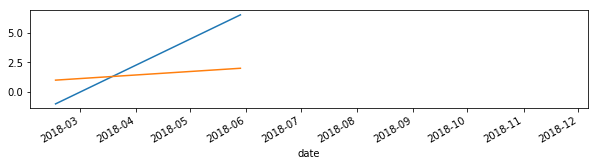

In [40]:
bb = bets[(bets['nb']==0) &  (bets['odds_ref'] > 10) & (bets['odds_ref'] < 20) & (bets['sub_category']!='kCOURSE_A_CONDITIONS') & (bets['pred'] > 0) & (bets['pred'] < 200) & (bets['target']!='kpred_stacked_mlp_sigmoid_1')  ].copy()


#bb = bb.groupby('id').filter(lambda b: len(b) <3 )
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_stacked_mlp_relu_1') & (bets['odds_ref']<30) & (bets['odds_ref']>10) & (bets['pred']>0)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()


# ok
#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_3']) & (bets['odds_ref']<20) & (bets['target']=='pred_knn_10_2') ].copy()


#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']>=3) & (bets['nb']<=3) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']=='pred_stacked_mlp_sigmoid_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * bb['pred']
#bb['bet'] = bb['bet'] * bb['pred']

graph_bb(bb, 'sub_category')




In [ ]:
bb[bb['declared_player_count']<10]['profit'].mean()


In [ ]:
program.df['category'].value_counts()

In [ ]:
mode = 'INTERNET'
mode.lower()